# AS - TME4

* Université Pierre et Marie Curie (UPMC)
* Master Données Apprentissage et Connaissances (DAC)
* Professeurs Patrick Gallinari et Ludovic Denoyer
* Etudiants Rémi Cadène et Michael Chen

In [3]:
require 'nn'
require 'gnuplot'
require 'image'
-- Génération de datasets

function generate_gauss(mu,sigma,nbEx)
   local x = torch.randn(nbEx, #mu)
   for i = 1,#mu do
      x[{{},{i}}] = x[{{},{i}}] * sigma[i] + mu[i]
   end
   return x
end

function generate_gaussDataset(gaussParams, nbEx)
   local x = generate_gauss(gaussParams[1][1], gaussParams[1][2], nbEx)
   local y = torch.ones(nbEx) * gaussParams[1][3]
   for i = 2,#gaussParams do
      x = x:cat(generate_gauss(gaussParams[i][1], gaussParams[i][2], nbEx),1)
      y = y:cat(torch.ones(nbEx) * gaussParams[i][3])
   end
   return x,y
end

-- Génération frontières

function toPlot2D(x,label,color)
   return {label, x[{{},1}], x[{{},2}], 'p ls 1 lc rgb "'..color..'"'}
end

function getRegionGrid(x,nbPoints)
   local xmin = x:min(1)[1]
   local xmax = x:max(1)[1]
   local axe1 = torch.linspace(xmin[1], xmax[1],nbPoints)
   local axe2 = torch.linspace(xmin[2], xmax[2],nbPoints)
   local gridX = torch.zeros(axe1:size(1) * axe2:size(1),2)
   i = 1
   for i1 = 1, axe1:size(1) do
      for i2 = 1, axe2:size(1) do
         gridX[i][1] = axe1[i1]
         gridX[i][2] = axe2[i2]
         i = i + 1
      end
   end
   return gridX
end

function plot_binaire_kernel(model, x, y, labels, colors, colorsReg, name)
    toPlot = {}
    -- Region
    xGrid = getRegionGrid(x,500)
    xGridInputs = torch.cat(xGrid, torch.cmul(xGrid[{{},1}], xGrid[{{},2}]),2)
    yGrid = model:forward(xGridInputs)
    yGrid = yGrid:sign()
    indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
    for i = 1, #labels do
       local selected = indices[yGrid:eq(labels[i])]
       table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
    end
    -- Points
    indices = torch.linspace(1,y:size(1),y:size(1)):long()
    for i = 1, #labels do
       local selected = indices[y:eq(labels[i])]
       table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
    end
    gnuplot.pngfigure(name)
    gnuplot.plot(toPlot)
    gnuplot.close()
end

function plot_network(name)
    toPlot = {}
    -- Region
    xGrid = getRegionGrid(x,500)
    xGridInputs = xGrid
    yGrid_m1 = module_1:forward(xGrid)
    yGrid_m2 = module_2:forward(yGrid_m1)
    yGrid    = module_3:forward(yGrid_m2)
    yGrid = yGrid:sign()
    indices = torch.linspace(1,yGrid:size(1),yGrid:size(1)):long()
    for i = 1, #labels do
       local selected = indices[yGrid:eq(labels[i])]
       table.insert(toPlot, toPlot2D(xGrid:index(1, selected), "region "..labels[i], colorsReg[i]))
    end
    -- Points
    indices = torch.linspace(1,y:size(1),y:size(1)):long()
    for i = 1, #labels do
       local selected = indices[y:eq(labels[i])]
       table.insert(toPlot, toPlot2D(x:index(1, selected), "classe "..labels[i], colors[i]))
    end
    gnuplot.pngfigure(name)a
    gnuplot.plot(toPlot)
    gnuplot.close()
end

[string "require 'nn'..."]:91: '=' expected near 'gnuplot': 

## Module ReQU

In [ ]:
local ReQU, parent = torch.class('nn.ReQU', 'nn.Module')

function ReQU:__init()
   parent.__init(self)
end
 
function ReQU:updateOutput(input)
   self.output = torch.pow(input,2)
   self.inputIsPositive = input:ge(0):double() -- création du masque 1 si positif, 0 sinon
   self.output:cmul(self.inputIsPositive) -- multiplication de nos inputs² par le masque
   return self.output
end
 
function ReQU:updateGradInput(input, gradOutput)
   -- On veut le gradient du Loss en fonction de notre entrée (input).
   -- On le décompose en gradient du Loss en fonction des sorties du module
   -- multiplié matriciellement par le gradient des sorties du module en fonction
   -- des entrées du module (calculé ci-dessous)
   self.gradInput = input * 2 
   self.gradInput:cmul(self.inputIsPositive)
   -- Ci dessous, gradOutput est le gradient du loss en fonction des 
   -- entrées du module suivant (ou sorties du module actuel)
   self.gradInput:cmul(gradOutput) 
   return self.gradInput
end

-- Le module ReQU n'ayant pas de paramètres, nous ne calculons pas le gradient du Loss en fonction des paramètres

## Module Linéaire sans biais (MyLinear)

In [1]:
local Linear, parent = torch.class('nn.MyLinear', 'nn.Module')

function Linear:__init(inputSize, outputSize)
   parent.__init(self)
   self.weight = torch.Tensor(outputSize, inputSize)
   self.gradWeight = torch.Tensor(outputSize, inputSize)
   self:reset()
end
 
function Linear:updateOutput(input)
   if input:dim() == 1 then
       self.output = self.weight * input -- cas où l'entrée est un vecteur
   else
       self.output = input * self.weight:t() -- cas où l'entrée est une matrice
   end
   return self.output
end

function Linear:updateGradInput(input, gradOutput)
    -- Le gradient des sorties en fonction des entrées est égal aux paramètres
   self.gradInput = self.weight:transpose(1,2) * gradOutput
   return self.gradInput
end
 
function Linear:accGradParameters(input, gradOutput)
   -- Le gradient des sorties en fonction des paramètres est égal aux entrées
   -- On additionne gradWeight dans le cas où on voudrait accumuler notre gradient
   self.gradWeight = self.gradWeight + gradOutput:reshape(gradOutput:size(1),1) * input:reshape(1,input:size(1))
   return self.gradWeight
end
 
function Linear:reset()
    -- Paramètres initialisés entre -1 et 1
    self.weight = self.weight:uniform() * 2 - 1
end

# Expériences

In [2]:
-- générations du XOR

labels = {-1,1}
gaussParams = {{{-5,-5},{1,1},labels[1]},
               {{5,5},{1,1},labels[1]},
               {{-5,5},{1,1},labels[2]},
               {{5,-5},{1,1},labels[2]}}
x,y = generate_gaussDataset(gaussParams, 100)
colors = {"red","blue"}
colorsReg = {"pink", "cyan"}

### MyLinear avec Kernel Trick

In [ ]:
nbIter = 1000
lr = 1e-4
criterion = nn.MSECriterion()

inputs = torch.cat(x, torch.cmul(x[{{},1}],x[{{},2}]),2)

model = nn.MyLinear(3,1)
for i = 1, nbIter do
   shuffle = torch.randperm(inputs:size(1))
   for j = 1, inputs:size(1) do
      id = shuffle[j]
      input = inputs[id]
      label = torch.Tensor{y[id]}
      model:zeroGradParameters()
      output = model:forward(input)
      loss = criterion:forward(output, label)
      df_do = criterion:backward(output, label)
      df_di = model:backward(input, df_do)
      model:updateParameters(lr)
      print(i,loss)
   end
end

plot_binaire_kernel(model, x, y, labels, colors, colorsReg, 'MyLinear_Kernel.png')

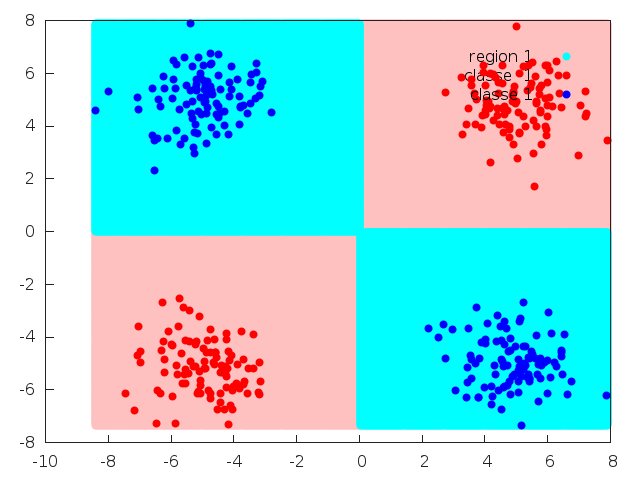

In [3]:
itorch.image(image.load('MyLinear_Kernel.png'))

## Comparaisons modèles avec biais (Linear) et sans biais (MyLinear)

### Fonction d'activation Tanh

In [ ]:
nbIter = 1000
lr = 1e-4
criterion = nn.MSECriterion()

module_1 = nn.Linear(2, 3)
module_2 = nn.Tanh()
module_3 = nn.Linear(3, 1)
for i = 1, nbIter do
   shuffle = torch.randperm(x:size(1))
   for j = 1, x:size(1) do
      id = shuffle[j]
      input = x[id]
      label = torch.Tensor{y[id]}
      module_1:zeroGradParameters()
      module_3:zeroGradParameters()
      output_m1  = module_1:forward(input)
      output_m2  = module_2:forward(output_m1)
      output     = module_3:forward(output_m2)
      loss       = criterion:forward(output, label)
      dloss_do   = criterion:backward(output, label)
      dloss_di   = module_3:backward(output_m2, dloss_do)
      dloss_dom1 = module_2:backward(output_m1, dloss_di)
      dloss_dom2 = module_1:backward(input, dloss_dom1)
      module_1:updateParameters(lr)
      module_3:updateParameters(lr)
      print(i,loss)
   end
end

plot_network('Linear_Tanh.png')

nbIter = 500
lr = 1e-3
criterion = nn.MSECriterion()

module_1 = nn.MyLinear(2, 3)
module_2 = nn.Tanh()
module_3 = nn.MyLinear(3, 1)

for i = 1, nbIter do
   shuffle = torch.randperm(x:size(1))
   mloss = 0
   for j = 1, x:size(1) do
      id = shuffle[j]
      input = x[id]
      label = torch.Tensor{y[id]}
      module_1:zeroGradParameters()
      module_3:zeroGradParameters()
      output_m1  = module_1:forward(input)
      output_m2  = module_2:forward(output_m1)
      output     = module_3:forward(output_m2)
      loss       = criterion:forward(output, label)
      mloss = mloss + loss
      dloss_do   = criterion:backward(output, label)
      dloss_di   = module_3:backward(output_m2, dloss_do)
      dloss_dom1 = module_2:backward(output_m1, dloss_di)
      dloss_dom2 = module_1:backward(input, dloss_dom1)
      module_1:updateParameters(lr)
      module_3:updateParameters(lr)  
   end
   print(i,mloss)
end
 
plot_network('MyLinear_Tanh.png')

Ci-dessous, on remarque que le modèle sans biais (à droite) ne peut pas apprendre une frontière de décision satisfaisante, contrairement au modèle avec biais (à gauche).

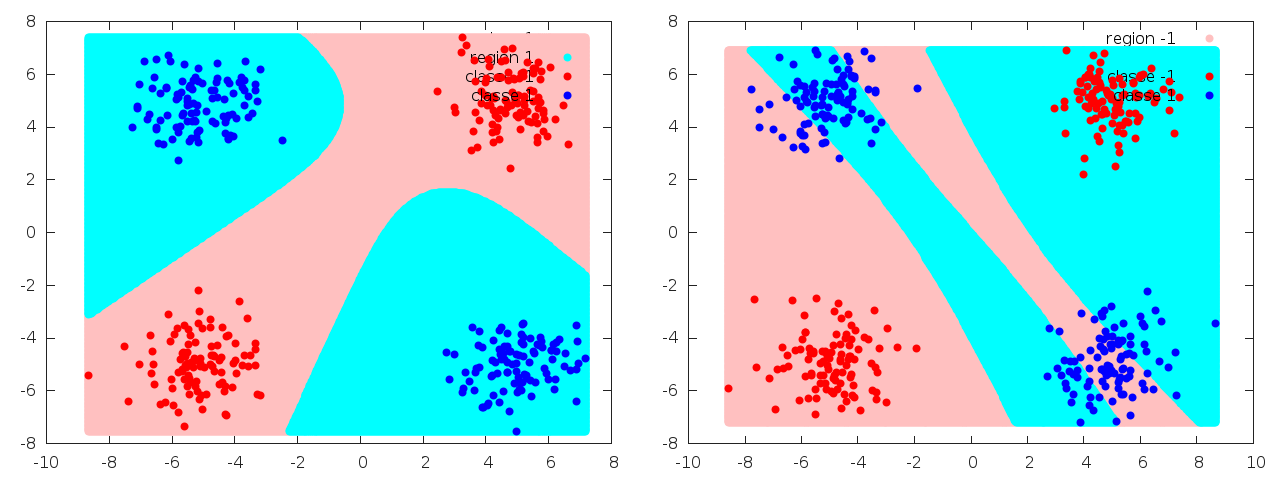

In [8]:
itorch.image{image.load('Linear_Tanh.png'), image.load('MyLinear_Tanh.png')}

### Fonction d'activation ReLU

In [ ]:
nbIter = 500
lr = 1e-5
criterion = nn.MSECriterion()

module_1 = nn.Linear(2, 3)
module_2 = nn.Tanh()
module_3 = nn.Linear(3, 1)
for i = 1, nbIter do
   shuffle = torch.randperm(x:size(1))
   for j = 1, x:size(1) do
      id = shuffle[j]
      input = x[id]
      label = torch.Tensor{y[id]}
      module_1:zeroGradParameters()
      module_3:zeroGradParameters()
      output_m1  = module_1:forward(input)
      output_m2  = module_2:forward(output_m1)
      output     = module_3:forward(output_m2)
      loss       = criterion:forward(output, label)
      dloss_do   = criterion:backward(output, label)
      dloss_di   = module_3:backward(output_m2, dloss_do)
      dloss_dom1 = module_2:backward(output_m1, dloss_di)
      dloss_dom2 = module_1:backward(input, dloss_dom1)
      module_1:updateParameters(lr)
      module_3:updateParameters(lr)
      print(i,loss)
   end
end

plot_network('Linear_ReLU.png')

nbIter = 500
lr = 1e-4
criterion = nn.MSECriterion()

module_1 = nn.MyLinear(2, 3)
module_2 = nn.Tanh()
module_3 = nn.MyLinear(3, 1)

for i = 1, nbIter do
   shuffle = torch.randperm(x:size(1))
   for j = 1, x:size(1) do
      id = shuffle[j]
      input = x[id]
      label = torch.Tensor{y[id]}
      module_1:zeroGradParameters()
      module_3:zeroGradParameters()
      output_m1  = module_1:forward(input)
      output_m2  = module_2:forward(output_m1)
      output     = module_3:forward(output_m2)
      loss       = criterion:forward(output, label)
      dloss_do   = criterion:backward(output, label)
      dloss_di   = module_3:backward(output_m2, dloss_do)
      dloss_dom1 = module_2:backward(output_m1, dloss_di)
      dloss_dom2 = module_1:backward(input, dloss_dom1)
      module_1:updateParameters(lr)
      module_3:updateParameters(lr)
      print(i,loss)
   end
end

plot_network('MyLinear_ReLU.png')

### Fonction d'activation ReQU

In [ ]:
nbIter = 1000
lr = 8e-6
criterion = nn.MSECriterion()

module_1 = nn.Linear(2, 3)
module_2 = nn.Tanh()
module_3 = nn.Linear(3, 1)
for i = 1, nbIter do
   shuffle = torch.randperm(x:size(1))
   for j = 1, x:size(1) do
      id = shuffle[j]
      input = x[id]
      label = torch.Tensor{y[id]}
      module_1:zeroGradParameters()
      module_3:zeroGradParameters()
      output_m1  = module_1:forward(input)
      output_m2  = module_2:forward(output_m1)
      output     = module_3:forward(output_m2)
      loss       = criterion:forward(output, label)
      dloss_do   = criterion:backward(output, label)
      dloss_di   = module_3:backward(output_m2, dloss_do)
      dloss_dom1 = module_2:backward(output_m1, dloss_di)
      dloss_dom2 = module_1:backward(input, dloss_dom1)
      module_1:updateParameters(lr)
      module_3:updateParameters(lr)
      print(i,loss)
   end
end

plot_network('Linear_ReQU.png')

nbIter = 1000
lr = 3e-6
criterion = nn.MSECriterion()


module_1 = nn.MyLinear(2, 3)
module_2 = nn.ReQU()
module_3 = nn.MyLinear(3, 1)

for i = 1, nbIter do
   shuffle = torch.randperm(x:size(1))
   mloss = 0
   for j = 1, x:size(1) do
      id = shuffle[j]
      input = x[id]
      label = torch.Tensor{y[id]}
      module_1:zeroGradParameters()
      module_3:zeroGradParameters()
      output_m1  = module_1:forward(input)
      output_m2  = module_2:forward(output_m1)
      output     = module_3:forward(output_m2)
      loss       = criterion:forward(output, label)
      mloss = mloss + loss
      dloss_do   = criterion:backward(output, label)
      dloss_di   = module_3:backward(output_m2, dloss_do)
      dloss_dom1 = module_2:backward(output_m1, dloss_di)
      dloss_dom2 = module_1:backward(input, dloss_dom1)
      module_1:updateParameters(lr)
      module_3:updateParameters(lr)
   end
   print(i,mloss)
end

plot_network('MyLinear_ReQU.png')

Ci-dessous, on remarque que le modèle sans biais (à droite) ne peut apprendre une frontière de décision satisfaisante, contrairement au modèle avec biais (à gauche).

De plus, la région blanche signifie que le résultat de la classification est nulle, alors qu'elle devrait être soit égale à -1 soit à 1.  Les points appartenant à cette zone blanche ne sont pas appris par le modèle Linéaire.
En effet, quand la première couche a pour sortie un vecteur négatif, la couche ReQU a pour sortie un vecteur nul. Sans biais, la seconde couche d'un neurone rend alors une valeur nulle. Ainsi, la backpropagation ne permet pas de mettre à jour les poids du réseau, car la dérivée du loss en fonction des poids est toujours nulle.

Le modèle avec biais (à gauche), quant à lui, n'est pas affecté par ce problème. Il suffit que le biais du neurone de la couche 3 apprenne les données qui auraient été situées dans la zone blanche.

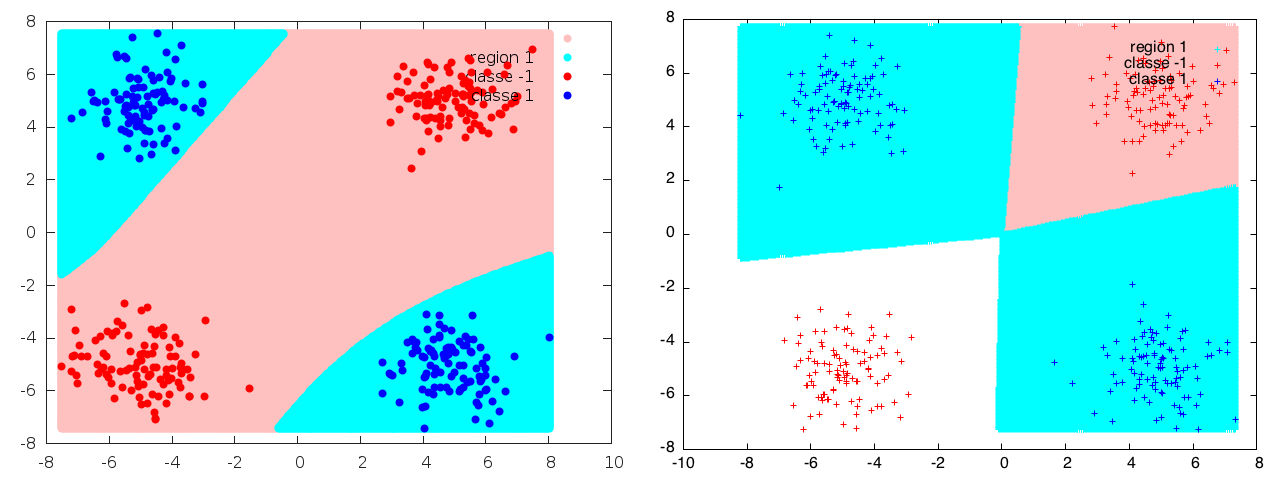

In [13]:
itorch.image{image.load('Linear_ReQU.png'), image.load('MyLinear_ReQU.png')}

On peut observer ci dessous le même phénomène avec la fonction d'activation ReLU.

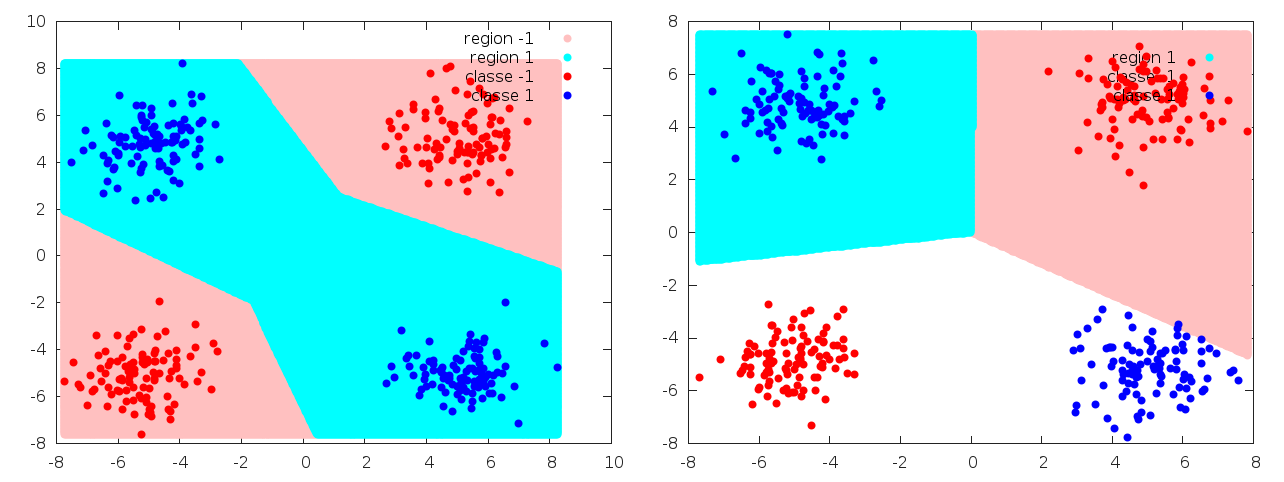

In [1]:
itorch.image{image.load('Linear_ReLU.png'), image.load('MyLinear_ReLU.png')}